In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import time 
import random

1 - Implementar el detector de fondo naive usando la mediana como
estimador. El algoritmo debe recibir el parámetro N (cantidad de
frames utilizados para la estimación) y el intervalo de tiempo para
recalcular el fondo. 

---


2 - Se deben generar las mascaras de foreground y aplicarlas a los frames
para segmentar los objetos en movimiento. 

---


3 - Comparar con alguno de los métodos vistos en la practica basados en
mezcla de gaussianas

In [21]:
max_int=np.iinfo(np.intp).max
filename = 'slow_traffic_small.mp4'

# Punto 1

In [22]:
def calculate_background(filename = 'vtest.avi',n_frames=max_int,time_limit=max_int,show_images=False):
    
    # Abrimos el archivo
    #-------------------
    capture = cv.VideoCapture(filename)

    if not capture.isOpened:
        print('Falla al abrir el archivo: ' + filename)
        exit(0)
        
    frames=[]
    counter=0
    start = time.time()
    while counter<n_frames:
        # Leemos un frame
        ret, frame = capture.read()
        if frame is None:
            break

        # Escribimos sobre la imagen el número de frame procesado
        cv.rectangle(frame, (10, 2), (100,20), (255,255,255), -1)
        cv.putText(frame, str(capture.get(cv.CAP_PROP_POS_FRAMES)), (15, 15),
                   cv.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))
        frames.append(frame)
        # mostramos frame original e imagen binaria background/foreground
        if(counter%10==0 and show_images):
            #cv.imshow('Frame', frame)
            plt.imshow(cv.cvtColor(frame, cv.COLOR_BGR2RGB), cmap='gray')
            plt.show()

        # Corresmos hasta que llegue el tiempo  o la cantidad de frames
        counter+=1
        time_passed = time.time()-start
        if(time_passed>time_limit):
            break
        keyboard = cv.waitKey(30)
        if keyboard == 'q' or keyboard == 27:
            break

    cv.destroyAllWindows()
    capture.release()
    
    total_time = time.time()-start
    print(f"Time taken: {total_time} seconds")
    
    median=np.median(frames,axis=0).astype(dtype=np.uint8)
    
    return median,frames


    

In [23]:
background,frames=calculate_background(n_frames=max_int,time_limit=max_int,show_images=False,filename = filename)

Time taken: 30.692132711410522 seconds


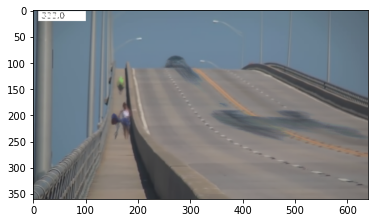

In [24]:
plt.imshow(cv.cvtColor(background, cv.COLOR_BGR2RGB), cmap='gray')
plt.show()

# Punto 2

In [25]:
def applyBackSubNaive(background,filename = 'vtest.avi',output_path = 'C:\\Users\\Colo\\Downloads\\Ejemplo1.avi',show_images=False):
    
    # Abrimos el archivo
    #-------------------
    
    start = time.time()
    
    capture = cv.VideoCapture(filename)

    if not capture.isOpened:
        print('Falla al abrir el archivo: ' + filename)
        exit(0)
        
    
    fourcc = cv.VideoWriter_fourcc('m', 'p', '4', 'v')
    
    output = cv.VideoWriter(output_path,fourcc,capture.get(cv.CAP_PROP_FPS),(int(capture.get(3)), int(capture.get(4))),False)
    
    dFrames=[]
    counter=0
    start = time.time()
    while True:
        # Leemos un frame
        ret, frame = capture.read()
        if frame is None:
            break

        frameGray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        backgroundGray=cv.cvtColor(background, cv.COLOR_BGR2GRAY)
        
        dframe = cv.absdiff(frameGray, backgroundGray)
        
        th, dframeT = cv.threshold(dframe, 35, 255, cv.THRESH_BINARY)
        
        dFrames.append(dframeT)
        

        # Escribimos sobre la imagen el número de frame procesado
        cv.rectangle(frame, (10, 2), (100,20), (255,255,255), -1)
        cv.putText(frame, str(capture.get(cv.CAP_PROP_POS_FRAMES)), (15, 15),
                   cv.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))
        # mostramos frame original e imagen binaria background/foreground
        if(counter%10==0 and show_images):
            #cv.imshow('FG Mask', fgMask)
            plt.imshow(dframeT, cmap='gray')
            plt.show()

        # Corresmos hasta que llegue el tiempo  o la cantidad de frames
        counter+=1
        time_passed = time.time()-start
        output.write(dframeT)
        keyboard = cv.waitKey(30)
        if keyboard == 'q' or keyboard == 27:
            break

    total_time = time.time()-start
    print(f"Time taken: {total_time} seconds")
    
    cv.destroyAllWindows()
    capture.release()
    
    
    return dFrames


    

In [26]:
dFrames=applyBackSubNaive(background,show_images=False,filename = filename)

Time taken: 40.05595874786377 seconds


# Punto 3

In [27]:
np.array(frames).shape

(914, 360, 640, 3)

In [28]:
quantityOfObjects=3

In [29]:
def applyBackSub(filename = 'vtest.avi',method='MOG2'):
    
    start = time.time()    
    if method == 'MOG2':
        backSub = cv.createBackgroundSubtractorMOG2()
    else:
        backSub = cv.createBackgroundSubtractorKNN()
        #backSub = cv.createBackgroundSubtractorKNN(detectShadows = True)
    # Abrimos el archivo
    #-------------------
    
    capture = cv.VideoCapture(filename)
    
    
    fgMasks=[]
    if not capture.isOpened:
        print('Falla al abrir el archivo: ' + filename)
        exit(0)

    # Corremos la sustraccion
    #------------------------
    while True:
        # Leemos un frame
        ret, frame = capture.read()
        if frame is None:
            break

        # Aplicamos la sustracción al frame leído
        #----------------------------------------
        fgMask = backSub.apply(frame)
        fgMasks.append(fgMask)

        # Escribimos sobre la imagen el número de frame procesado
        cv.rectangle(frame, (10, 2), (100,20), (255,255,255), -1)
        cv.putText(frame, str(capture.get(cv.CAP_PROP_POS_FRAMES)), (15, 15),
                   cv.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))

        # Corresmos hasta que termine o apriete escape
        keyboard = cv.waitKey(30)
        if keyboard == 'q' or keyboard == 27:
            break
    
    time_passed = time.time()-start
    print(f"Time taken: {time_passed} seconds")
    cv.destroyAllWindows()
    capture.release()
    return fgMasks,backSub

In [30]:
mogMasks,mogbackSub=applyBackSub(filename = filename, method='MOG2')

Time taken: 42.394437074661255 seconds


In [31]:
knnMasks,knnbackSub=applyBackSub(filename = filename, method='KNN')

Time taken: 42.568312883377075 seconds


In [32]:
objectsToCompare= [int(np.quantile(list(range(len(frames))), i/quantityOfObjects)) for i in range(1,quantityOfObjects+1)]

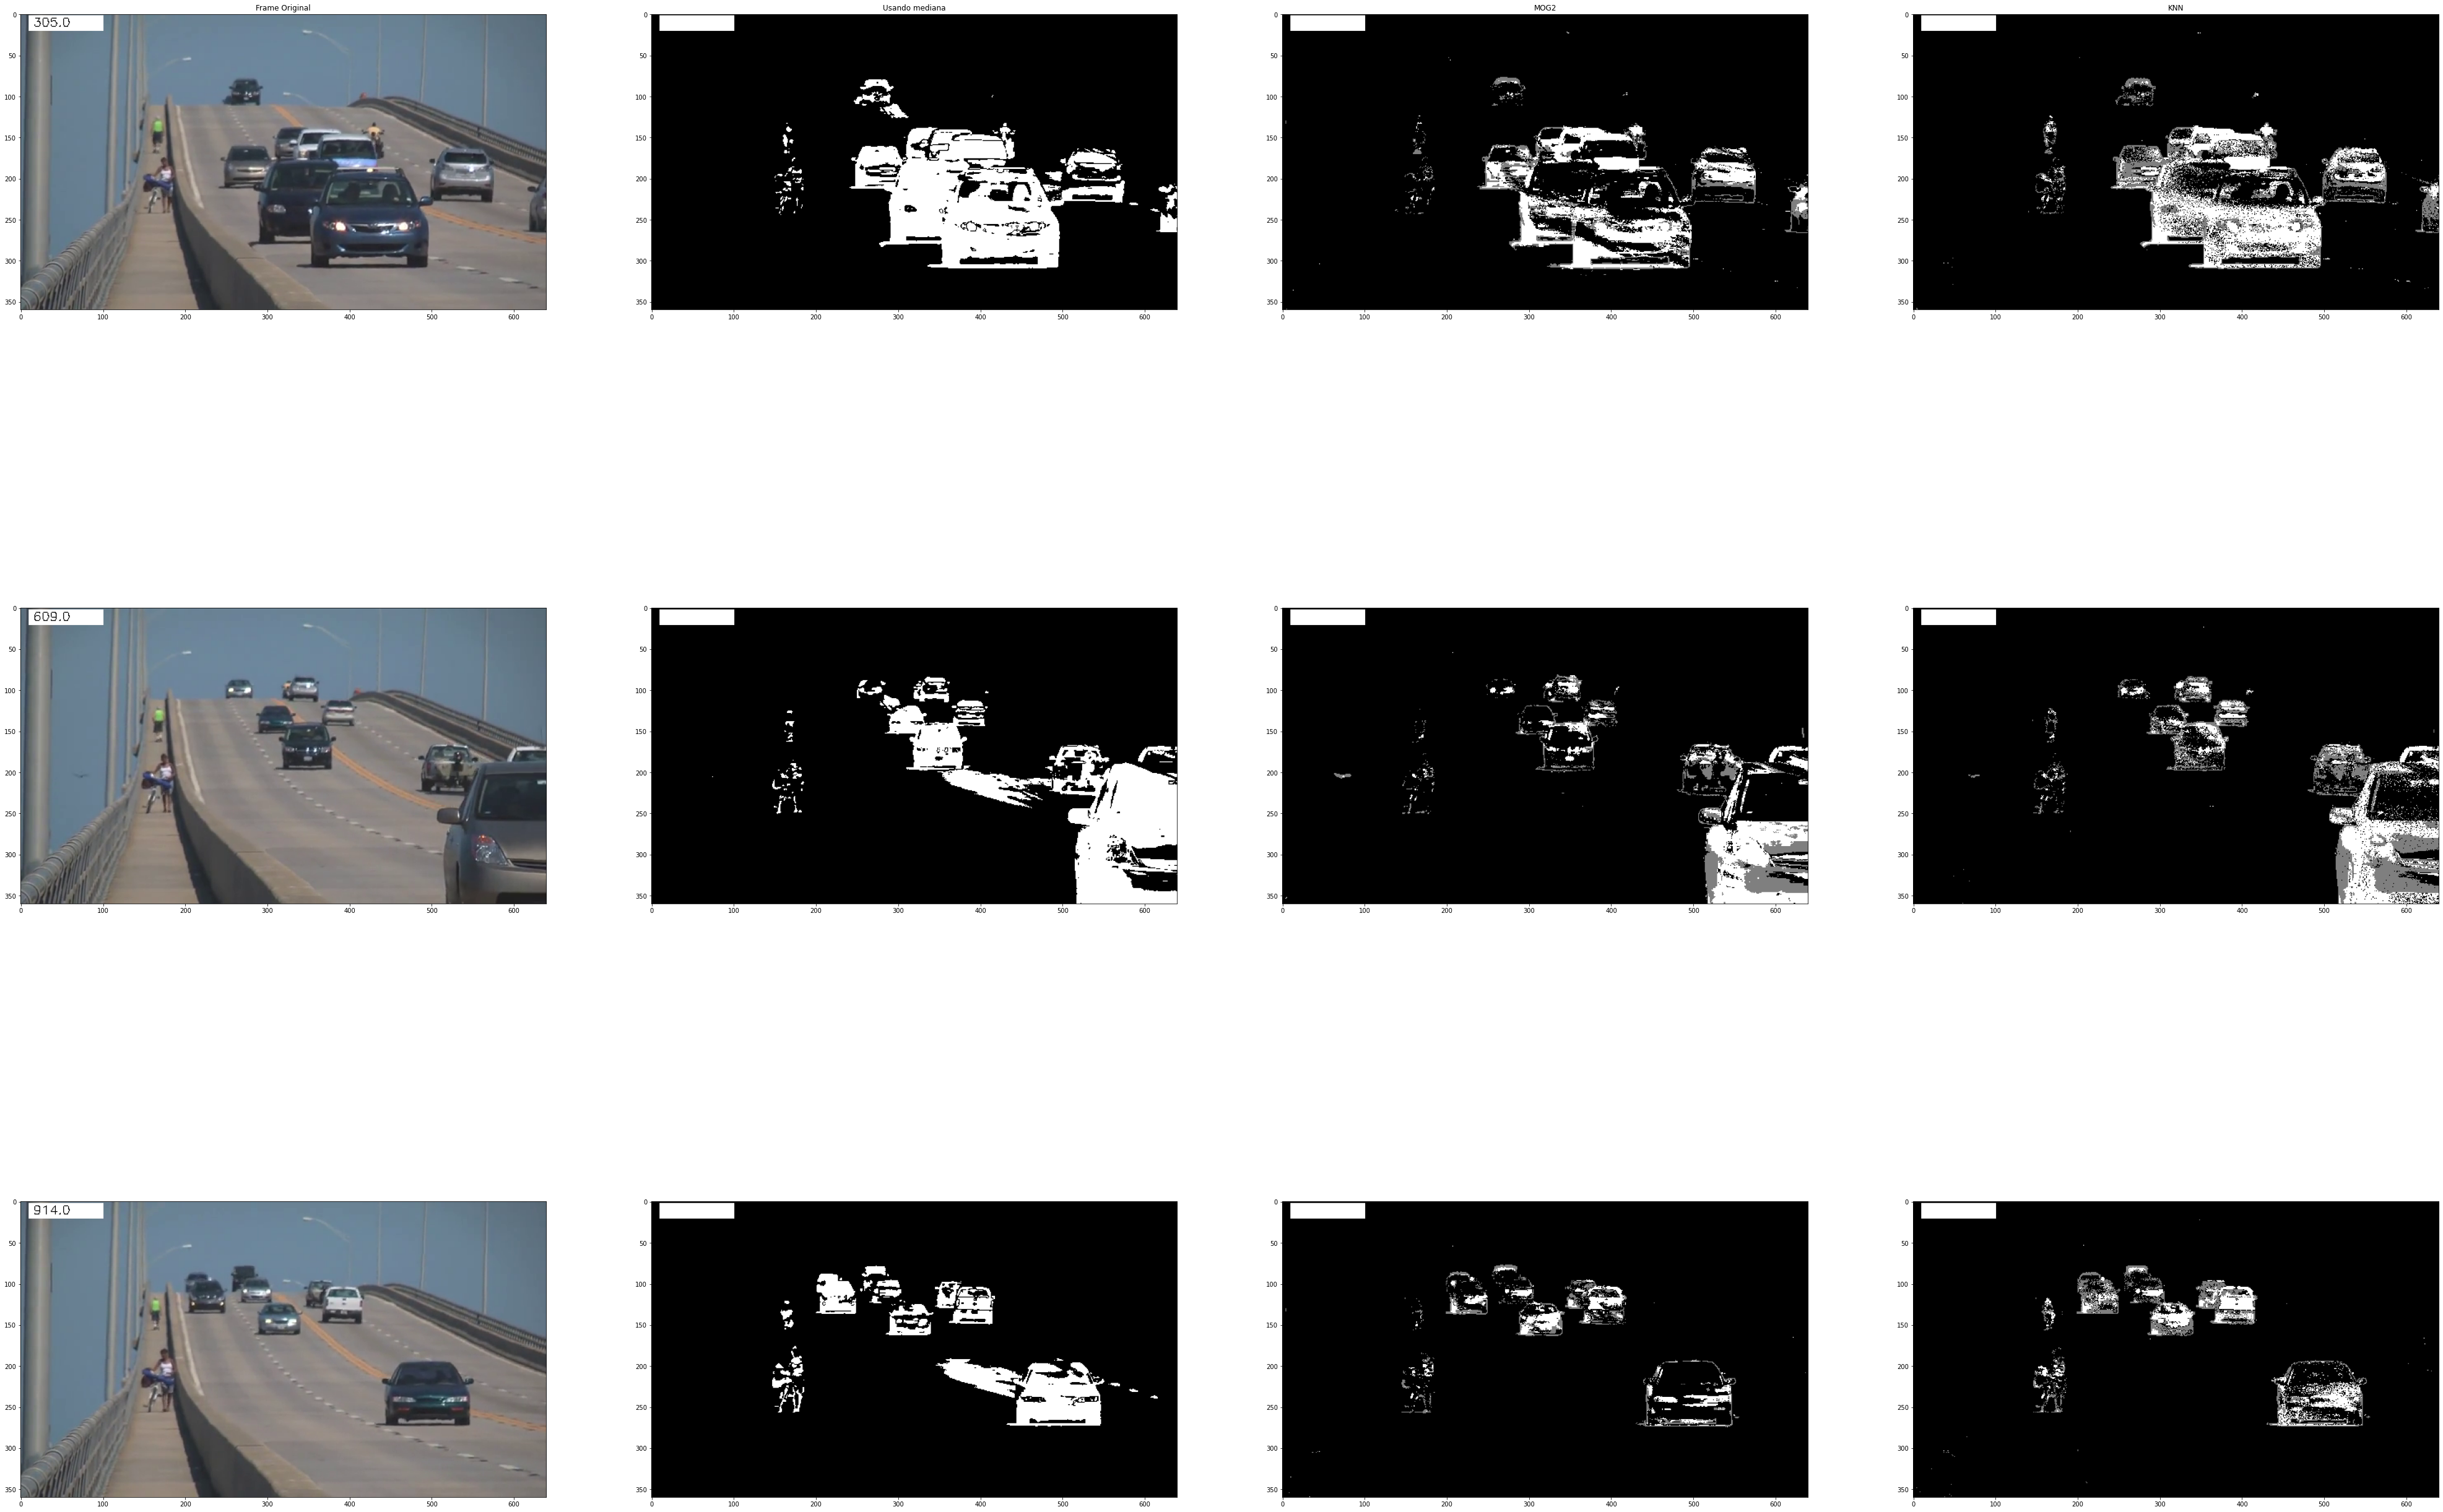

In [33]:
fig, ax = plt.subplots(quantityOfObjects, 4, figsize=(70,50))
cols = ["Frame Original","Usando mediana","MOG2","KNN"]

for i,obj in enumerate(objectsToCompare):
    ax[i][0].imshow(cv.cvtColor(frames[obj], cv.COLOR_BGR2RGB), cmap='gray')
    ax[i][1].imshow(cv.cvtColor(dFrames[obj], cv.COLOR_BGR2RGB), cmap='gray')
    ax[i][2].imshow(cv.cvtColor(mogbackSub.apply(frames[obj]),cv.COLOR_BGR2RGB),cmap='gray')
    ax[i][3].imshow(cv.cvtColor(knnbackSub.apply(frames[obj]),cv.COLOR_BGR2RGB),cmap='gray')
    
for axi, col in zip(ax[0], cols):
    axi.set_title(col)

# Conclusion
A modo de conclusion podriamos decir que al menos para este caso en particular, el algoritmo basado en medianas(Naive) da mejor resultado a la hora de extraer el fondo que el de MOG2 y KNN.

En cuanto a la performance, notamos que al menos los 3 procesos usados dan una performance similar con respecto al tiempo que toman, si bien el metodo naive necesita un poco mas tiempo, siendo que este tiene 2 pasos, primero calcula el background y despues obtener las foreground masks, creemos que es debido a que el codigo no tiene una optimizacion adecuada, ya que por ejemplo lee 2 veces el video a la hora de hacer los 2 procesos.